In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# IMAGE PREPROCESSING

In [5]:
input_shape = (224, 224, 3)
num_classes = 2

def image_processor(path):
  image = []
  labels = []

  for label, category in enumerate(['infected', 'uninfected']):
      category_path = os.path.join(path, category)

      for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        img = cv2.imread(img_path)

        if img is not None:
          img = cv2.resize(img, (224, 224))
          img = img.astype('float32') / 255.0
          image.append(img)
          labels.append(label)
  return np.array(image), np.array(labels)


train_path = '/content/drive/MyDrive/splited dataset notduplicate/train'
test_path = '/content/drive/MyDrive/splited dataset notduplicate/test'
train_images, train_labels = image_processor(train_path)
test_images, test_labels = image_processor(test_path)


In [6]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1539, 224, 224, 3)
(1539,)
(385, 224, 224, 3)
(385,)


In [7]:
# Define data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()



In [8]:
training_data = train_datagen.flow(train_images, train_labels, batch_size=32)
#validation_data = train_datagen.flow(val_images, val_labels, batch_size=32)
test_data = test_datagen.flow(test_images, test_labels, batch_size=32)

In [ ]:
batch_size = 32
# Check the number of images in validation data
num_val_images = len(test_data) * batch_size
print(f'Number of images in validation data: {num_val_images}')

Number of images in validation data: 416


# TESTING MODELS

## ---MOBILENET V2 ---

In [14]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune MobileNet - Unfreeze some layers
#for layer in base_model.layers[-20:]:
    #layer.trainable = True

base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
 if layer.name == 'block_16_expand':
    set_trainable= True
 if set_trainable == True:
    layer.trainable = True
 else:
    layer.trainable = False

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.8)(x)
outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
# Compute class weights and convert to dictionary
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

# Define learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [17]:
# history = model.fit(
#     train_data,
#     steps_per_epoch=train_data.samples // train_data.batch_size,
#     validation_data=test_data,
#     validation_steps=test_data.samples // test_data.batch_size,
#     epochs=5
# )

# Train the model
history = model.fit(training_data,
                    epochs=10,  # Increase epochs if needed
                    validation_data=test_data,
                    class_weight=class_weights_dict,
                    callbacks=[reduce_lr])

Epoch 1/10
49/49 [==============================] - 26s 364ms/step - loss: 0.3035 - accuracy: 0.9623 - val_loss: 0.4761 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 2/10
49/49 [==============================] - 19s 397ms/step - loss: 0.1561 - accuracy: 0.9935 - val_loss: 0.4029 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 3/10
49/49 [==============================] - 18s 365ms/step - loss: 0.1078 - accuracy: 0.9948 - val_loss: 0.0787 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
49/49 [==============================] - 18s 369ms/step - loss: 0.0756 - accuracy: 0.9981 - val_loss: 0.7019 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 5/10
49/49 [==============================] - 20s 407ms/step - loss: 0.0480 - accuracy: 0.9987 - val_loss: 0.0996 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 6/10
49/49 [==============================] - 18s 365ms/step - loss: 0.0313 - accuracy: 0.9994 - val_loss: 0.0298 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 7/10
49/49 [==============================] - 18s 363ms/st

In [18]:
# Make predictions on the test dataset
predictions = model.predict(test_images)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Assuming binary classification

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

13/13 [==============================] - 1s 44ms/step - loss: 0.0354 - accuracy: 0.9896
Test accuracy: 98.96%


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       158
           1       0.98      1.00      0.99       227

    accuracy                           0.99       385
   macro avg       0.99      0.99      0.99       385
weighted avg       0.99      0.99      0.99       385



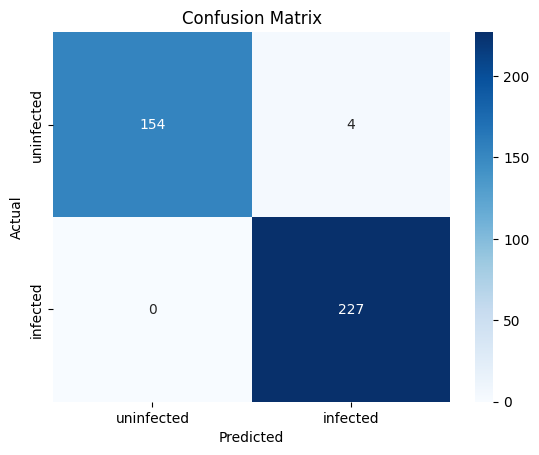

In [19]:


# Print the classification report
print(classification_report(test_labels, predicted_classes))

# Generate the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['uninfected', 'infected'], yticklabels=['uninfected', 'infected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
model.save('/content/drive/MyDrive/models/MobileNetV2.keras')

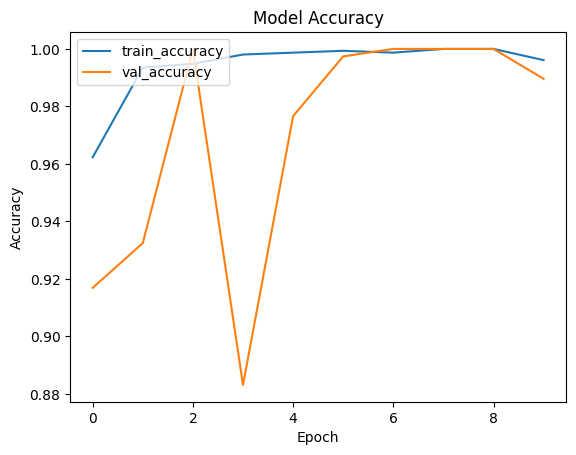

In [20]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

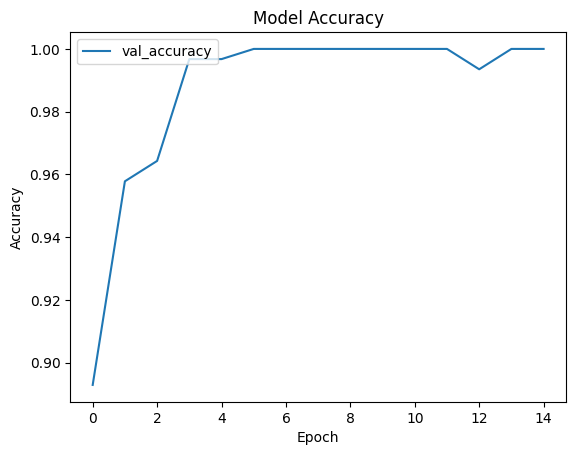

In [ ]:

plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

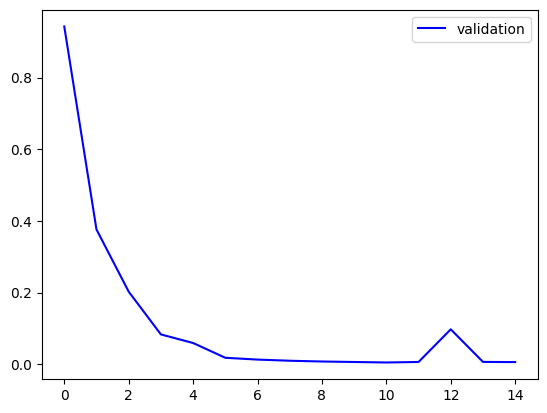

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

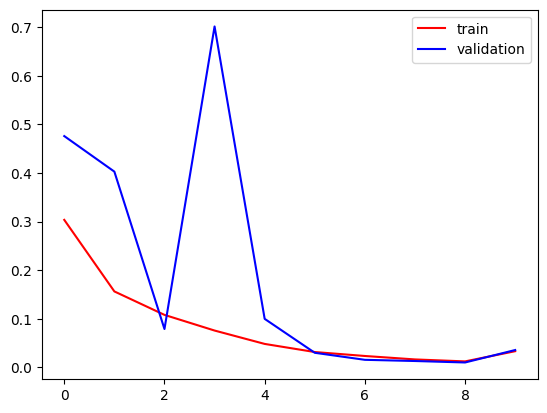

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()